# Load data

In [1]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
# Transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load train set
train_set = dsets.CIFAR10('../data/', train=True, download=True, transform=transform_train)

# Load test set (using as validation)
val_set = dsets.CIFAR10('../data/', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


# Import models A
---

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os.path
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from copy import deepcopy
from resnet import ResNet18

In [4]:
# Select device
# device = torch.device('cuda')
device = torch.device('cuda:1')

## Import model A

In [5]:
# Check for model
if os.path.isfile('models/vit-t-classifier-from_pretrained_mae.pt'):
    # Load saved model
    print('Loading saved model')
    model_A = torch.load('models/vit-t-classifier-from_pretrained_mae.pt').to(device)
else:
    print('Model not available')

Loading saved model


## import surrogate A

In [6]:
from fastshap import ImageSurrogate
from fastshap.utils import MaskLayer2d, KLDivLoss, DatasetInputOnly

In [7]:
# Check for model
if os.path.isfile('./models/cifar_c10_vit_dim192+768_classifier_mae_surrogate.pt'):
    print('Loading saved surrogate model')
    surr_A = torch.load('./models/cifar_c10_vit_dim192+768_classifier_mae_surrogate.pt').to(device)
    surrogate_A = ImageSurrogate(surr_A, width=32, height=32, superpixel_size=2)

else:
    print('Model not available')

Loading saved surrogate model


## Import Explainer A

In [8]:
from unet import UNet
from fastshap import FastSHAP

In [9]:
# Check for model
if os.path.isfile('./models/cifar_c10_vit_dim192+768_classifier_mae_explainer.pt'):
    print('Loading saved explainer model')
    explainer_A = torch.load('./models/cifar_c10_vit_dim192+768_classifier_mae_explainer.pt').to(device)
    fastshap_A = FastSHAP(explainer_A, surrogate_A, link=nn.LogSoftmax(dim=1))

else:
    print('Model not available')

Loading saved explainer model


# Import Models B
---

## Import Model B

In [10]:
# Check for model
if os.path.isfile('models/vit-t-classifier-from_pretrained_mae.pt'):
    # Load saved model
    print('Loading saved model')
    model_B = torch.load('models/vit-t-classifier-from_pretrained_mae.pt').to(device)
else:
    print('Model not available')

Loading saved model


## Import surrogates B

In [11]:
# Check for model
if os.path.isfile('./models/cifar_c10_vit_classifier_mae_surrogate_resnet.pt'):
    print('Loading saved surrogate model')
    surr_B = torch.load('./models/cifar_c10_vit_classifier_mae_surrogate_resnet.pt').to(device)
    surrogate_B = ImageSurrogate(surr_B, width=32, height=32, superpixel_size=2)

else:
    print('Model not available')

Loading saved surrogate model


## Import explainer B

In [12]:
# Check for model
if os.path.isfile('./models/cifar_c10_vit_classifier_mae_surr_resnet_explainer.pt'):
    print('Loading saved explainer model')
    explainer_B = torch.load('./models/cifar_c10_vit_classifier_mae_surr_resnet_explainer.pt').to(device)
    fastshap_B = FastSHAP(explainer_B, surrogate_B, link=nn.LogSoftmax(dim=1))

else:
    print('Model not available')

Loading saved explainer model


## Initialize dataset

In [13]:
dset = val_set
dset_size = 100
# dset_size = 10
targets = np.array(dset.targets)
num_classes = targets.max() + 1
classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Plot individual images and values

In [14]:
import matplotlib.pyplot as plt

In [15]:
def plot_img(x):
    mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
    std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
    im = x.numpy() * std + mean    
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    plt.imshow(im, vmin=0, vmax=1)
    plt.show()

In [16]:
def plot_values(value):
#     plt.imshow(value, cmap='seismic',vmin=-m, vmax=m )
    plt.imshow(value, cmap='seismic')

# Collect data

## create dataframe to store results

In [17]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
columns =  ['y_label','y_A','y_prob_correct_A', 'y_prob_A', 'A','y_B','y_prob_correct_B', 'y_prob_B', 'B']
dset_idxs = np.array(range(dset_size))
results = pd.DataFrame(columns = columns, index = dset_idxs)

In [18]:
results.head()

,y_label,y_A,y_prob_correct_A,y_prob_A,A,y_B,y_prob_correct_B,y_prob_B,B
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## collect data

data collected according to the predictions of the surrogates, now that A and B use the same original model

In [19]:
def get_pred(dset, dset_size, idx, model, model_name, x, y):
    y_pred = model(x).softmax(dim=1).detach()
    y_pred_class = np.argmax(y_pred)

    # store values
    results.iloc[idx]['y_' + model_name] = y_pred_class.item()
    results.iloc[idx]['y_prob_correct_' + model_name] = y_pred[0][y].item()
    results.iloc[idx]['y_prob_' + model_name] = y_pred[0][y_pred_class.item()].item()

    if (y == y_pred_class): 
        results.iloc[idx][model_name] = 1
    else:
        results.iloc[idx][model_name] = 0

In [20]:
def collect_data(dset, dset_size, results, model_A, model_B):
    for idx in range(dset_size):
        x, y = zip(*[dset[idx]])
        x = torch.stack(x)
        y = y[0]
        
        results.iloc[idx]['y_label'] = y
        get_pred(dset, dset_size, idx, model_A, 'A', x, y)
        get_pred(dset, dset_size, idx, model_B, 'B', x, y)

In [21]:
def check_results(idx,  results, model_name):
    x, y = zip(*[dset[idx]])
    x = x[0]
    y = y[0]
    print(f'Label = {classes[y]}, {y}')
    y_predicted = results.iloc[idx]['y_' + model_name] 
    print(f'Predicted = {classes[y_predicted]} , {y_predicted}' )
    plot_img(x)

In [22]:
def get_pred_surr(dset, dset_size, idx, surr_model, surr_model_name, x, y):
    y_pred = surr_model(
                x.to(device),
                torch.ones(num_classes, surr_model.num_players, device=device)
            ).softmax(dim=1).detach().cpu()
    y_pred_class = np.argmax(y_pred)

    # store values
    results.iloc[idx]['y_' + surr_model_name] = y_pred_class.item()
    results.iloc[idx]['y_prob_correct_' + surr_model_name] = y_pred[0][y].item()
    results.iloc[idx]['y_prob_' + surr_model_name] = y_pred[0][y_pred_class.item()].item()

    if (y == y_pred_class): 
        results.iloc[idx][surr_model_name] = 1
    else:
        results.iloc[idx][surr_model_name] = 0

In [23]:
def collect_data_surr(dset, dset_size, results, model_A, model_B):
    for idx in range(dset_size):
        x, y = zip(*[dset[idx]])
        x = torch.stack(x)
        y = y[0]
        
        results.iloc[idx]['y_label'] = y
        get_pred_surr(dset, dset_size, idx, model_A, 'A', x, y)
        get_pred_surr(dset, dset_size, idx, model_B, 'B', x, y)

In [24]:
collect_data_surr(dset, dset_size, results, surrogate_A, surrogate_B)

In [25]:
results

,y_label,y_A,y_prob_correct_A,y_prob_A,A,y_B,y_prob_correct_B,y_prob_B,B
0,3,3,0.82016,0.82016,1,3,0.999194,0.999194,1
1,8,8,0.999809,0.999809,1,8,0.998843,0.998843,1
2,8,8,0.713794,0.713794,1,8,0.999889,0.999889,1
3,0,0,0.854478,0.854478,1,0,0.999819,0.999819,1
4,6,4,0.307715,0.66813,0,6,1.0,1.0,1
5,6,6,0.987986,0.987986,1,6,1.0,1.0,1
6,1,1,0.430352,0.430352,1,1,0.999661,0.999661,1
7,6,6,0.98578,0.98578,1,6,0.999985,0.999985,1
8,3,4,0.203985,0.457237,0,3,0.99993,0.99993,1
9,1,1,0.899138,0.899138,1,1,0.999328,0.999328,1


# Classify samples into sets

In [26]:
A_wrong_B_wrong = results[(results['A'] == 0) & (results['B'] == 0)] 
A_wrong_B_correct = results[(results['A'] == 0) & (results['B'] == 1)] 
A_correct_B_wrong = results[(results['A'] == 1) & (results['B'] == 0)] 
A_correct_B_correct = results[(results['A'] == 1) & (results['B'] == 1)] 

In [27]:
A_wrong_B_wrong.head()

,y_label,y_A,y_prob_correct_A,y_prob_A,A,y_B,y_prob_correct_B,y_prob_B,B
36,4,5,0.127083,0.599572,0,7,0.008976,0.587063,0
52,0,6,0.001451,0.95144,0,3,0.000021,0.85868,0
58,4,6,0.004732,0.555263,0,3,0.000301,0.830277,0
78,3,5,0.292869,0.683442,0,5,0.000229,0.996354,0
85,5,7,0.064098,0.565763,0,7,0.077068,0.917682,0


In [28]:
A_wrong_B_correct.head()

,y_label,y_A,y_prob_correct_A,y_prob_A,A,y_B,y_prob_correct_B,y_prob_B,B
4,6,4,0.307715,0.66813,0,6,1.0,1.0,1
8,3,4,0.203985,0.457237,0,3,0.99993,0.99993,1
24,5,4,0.143967,0.809479,0,5,0.999912,0.999912,1
25,2,4,0.022101,0.588086,0,2,0.998359,0.998359,1
27,0,6,0.108551,0.330009,0,0,0.999997,0.999997,1


In [32]:
A_wrong_B_correct.sample(frac=1).head()

,y_label,y_A,y_prob_correct_A,y_prob_A,A,y_B,y_prob_correct_B,y_prob_B,B
28,9,1,0.458923,0.539353,0,9,0.999602,0.999602,1
25,2,4,0.022101,0.588086,0,2,0.998359,0.998359,1
4,6,4,0.307715,0.66813,0,6,1.0,1.0,1
76,9,0,0.413474,0.551235,0,9,1.0,1.0,1
53,3,5,0.2555,0.610833,0,3,0.853883,0.853883,1


In [57]:
A_correct_B_wrong.head()

,y_label,y_A,y_prob_correct_A,y_prob_A,A,y_B,y_prob_correct_B,y_prob_B,B
15,8,8,0.984549,0.984549,1,0,0.231359,0.740915,0
20,7,7,0.916804,0.916804,1,5,0.283719,0.715177,0
61,3,3,0.808787,0.808787,1,5,0.022438,0.97741,0


In [58]:
A_correct_B_correct.head()

,y_label,y_A,y_prob_correct_A,y_prob_A,A,y_B,y_prob_correct_B,y_prob_B,B
0,3,3,0.82016,0.82016,1,3,0.999194,0.999194,1
1,8,8,0.999809,0.999809,1,8,0.998843,0.998843,1
2,8,8,0.713794,0.713794,1,8,0.999889,0.999889,1
3,0,0,0.854478,0.854478,1,0,0.999819,0.999819,1
5,6,6,0.987986,0.987986,1,6,1.0,1.0,1


# Check individual Results

In [62]:
# Sample indices for each category
idx_A_wrong_B_wrong = 36
idx_A_wrong_B_correct = 4 
idx_A_correct_B_wrong = 15
idx_A_correct_B_correct = 0

In [33]:
indices = [28, 25, 4, 76, 53]

# Check explanations
---

In [34]:
def visualize_all_classes(model, surrogate, fastshap):
    # Select one image from each class
    dset = val_set
    targets = np.array(dset.targets)
    num_classes = targets.max() + 1
    inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
    inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
    x, y = zip(*[dset[ind] for ind in inds])
    x = torch.stack(x)

    # Get explanations
    values = fastshap.shap_values(x.to(device))

    # Get predictions
    pred = surrogate(
        x.to(device),
        torch.ones(num_classes, surrogate.num_players, device=device)
    ).softmax(dim=1).cpu().data.numpy()

    fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))

    for row in range(num_classes):
        # Image
        classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
        mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
        std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
        im = x[row].numpy() * std + mean
        im = im.transpose(1, 2, 0).astype(float)
        im = np.clip(im, a_min=0, a_max=1)
        axarr[row, 0].imshow(im, vmin=0, vmax=1)
        axarr[row, 0].set_xticks([])
        axarr[row, 0].set_yticks([])
        axarr[row, 0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)

        # Explanations
        m = np.abs(values[row]).max()
        for col in range(num_classes):
            axarr[row, col + 1].imshow(values[row, col], cmap='seismic', vmin=-m, vmax=m)
            axarr[row, col + 1].set_xticks([])
            axarr[row, col + 1].set_yticks([])
            if col == y[row]:
                axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
            else:
                axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)

            # Class labels
            if row == 0:
                axarr[row, col + 1].set_title('{}'.format(classes[y[col]]), fontsize=14)

    plt.tight_layout()
    plt.show()

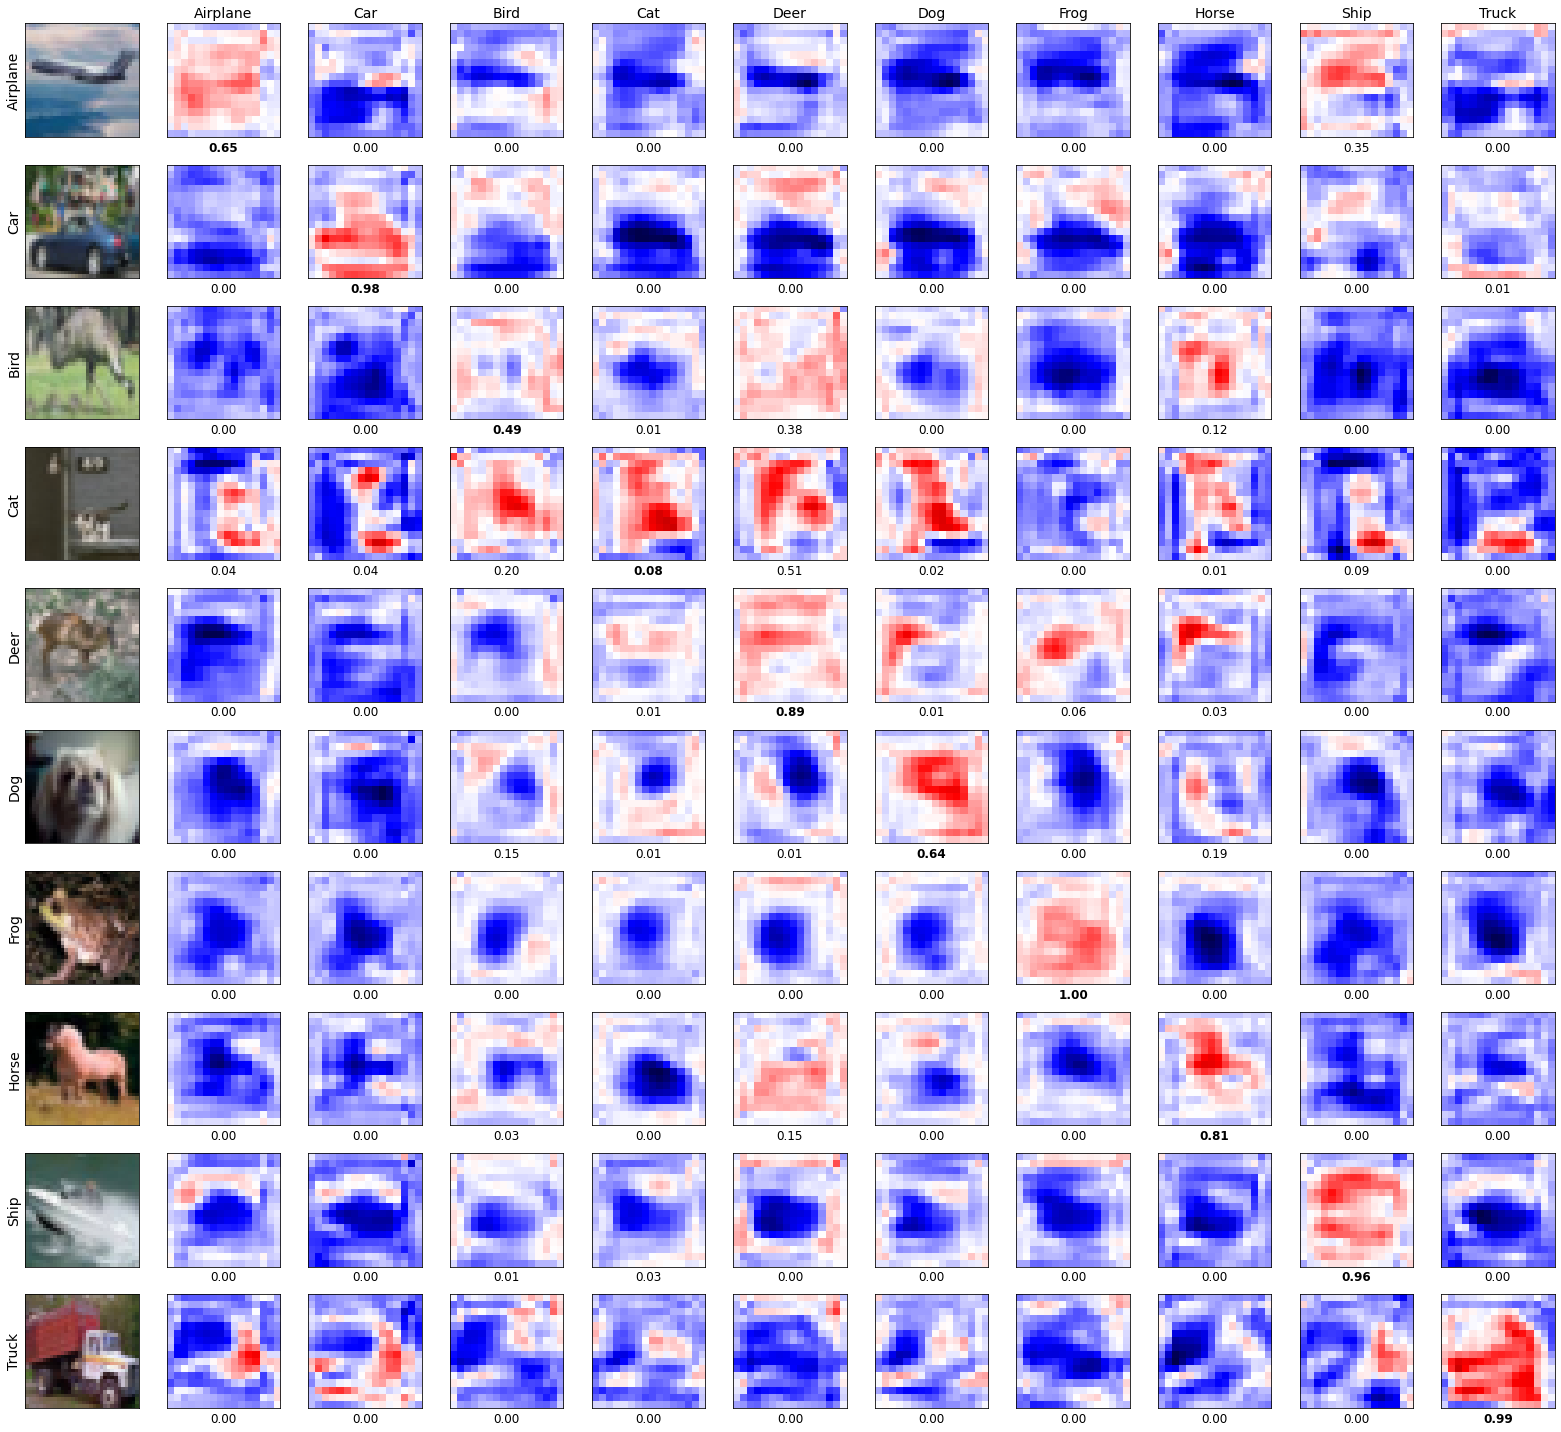

In [60]:
visualize_all_classes(model_A, surrogate_A, fastshap_A)

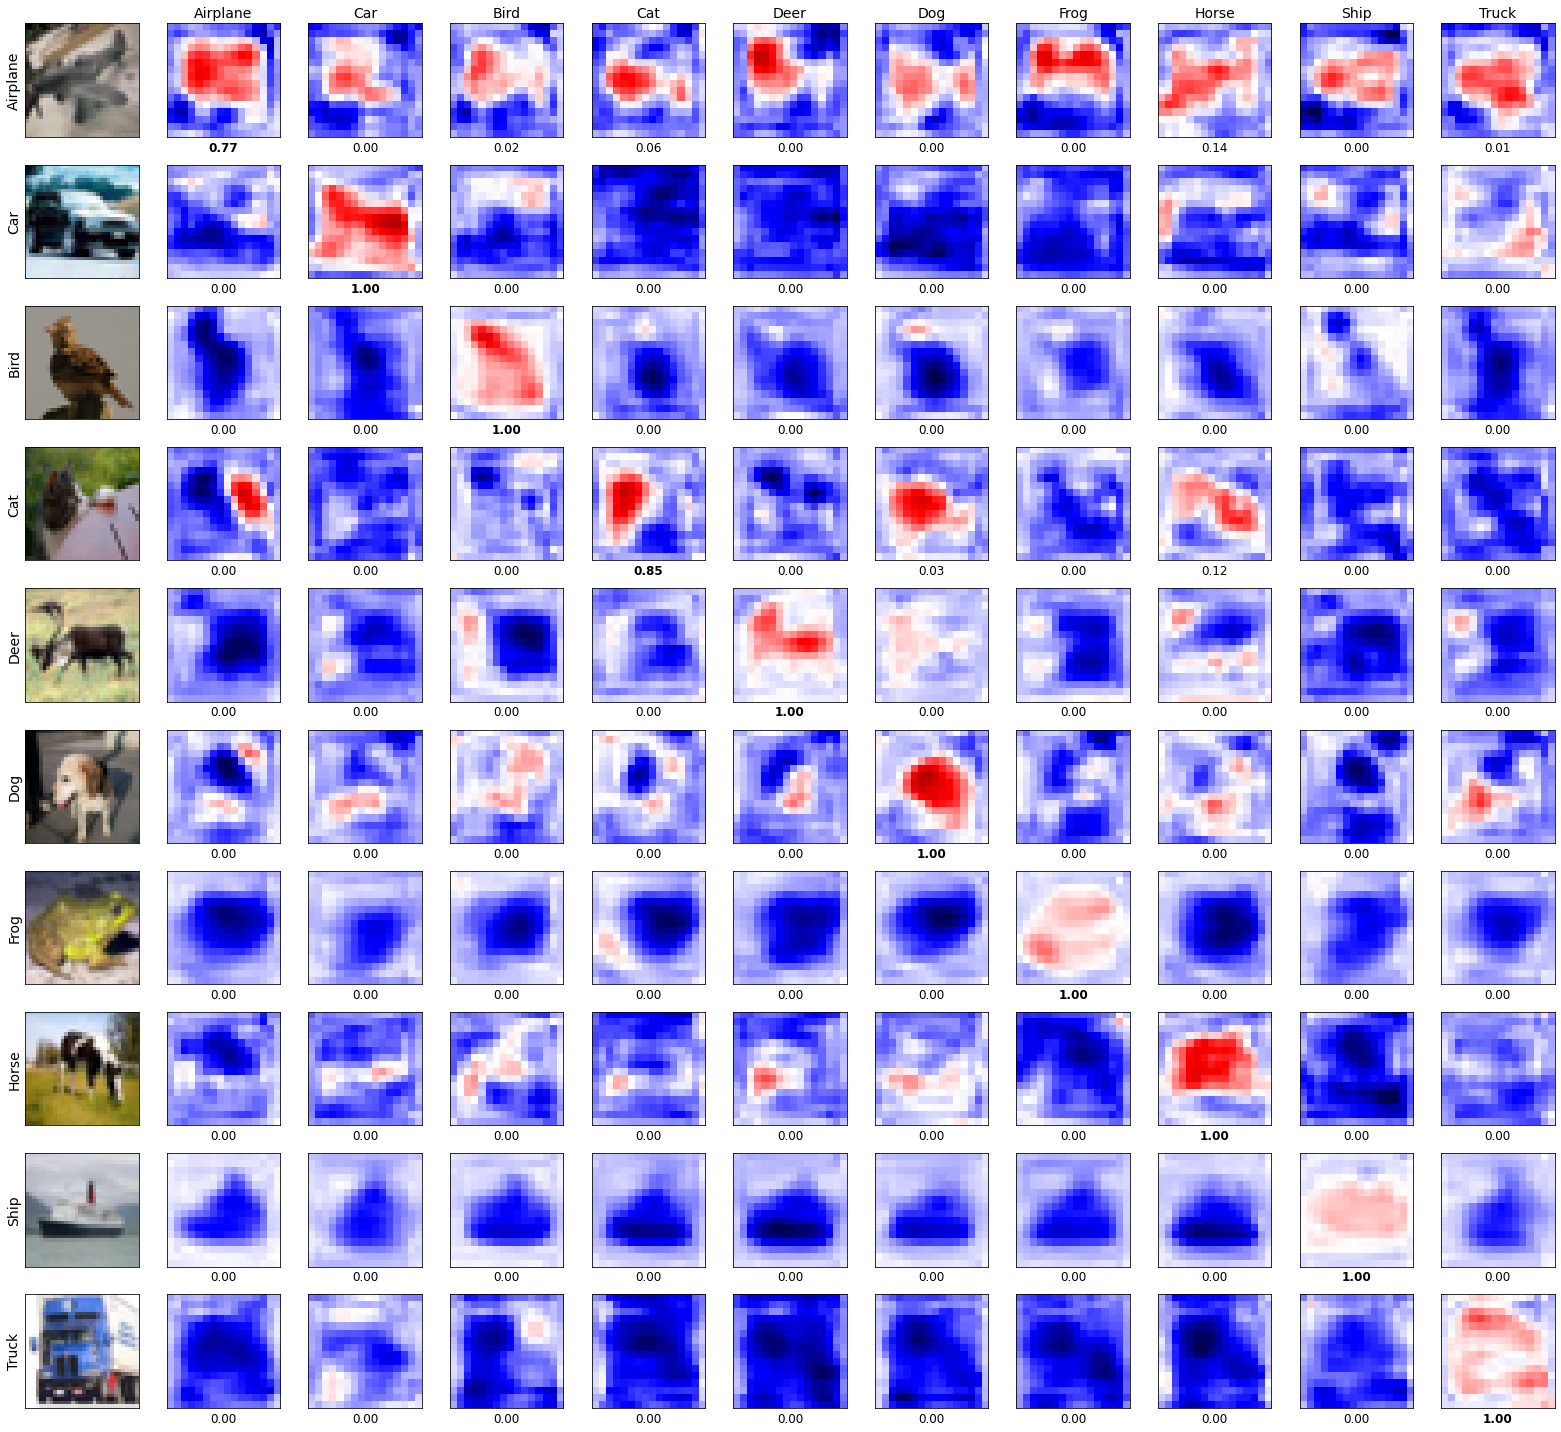

In [61]:
visualize_all_classes(model_B, surrogate_B, fastshap_B)

In [36]:
def visualize_one_sample(idx, model, surrogate, fastshap):
    # Select one image from each class
    dset = val_set
    targets = np.array(dset.targets)
    num_classes = targets.max() + 1
    x, y = zip(*[dset[idx]])
    x = torch.stack(x)

    # Get explanations
    values = fastshap.shap_values(x.to(device))

    # Get predictions
    pred = surrogate(
        x.to(device),
        torch.ones(num_classes, surrogate.num_players, device=device)
    ).softmax(dim=1).cpu().data.numpy()
    
    # Get model predictions
    y_pred = model(x.to(device)).softmax(dim=1).detach().cpu()
    y_pred_class = np.argmax(y_pred)

#     fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))
    fig, axarr = plt.subplots(1, num_classes + 1, figsize=(22, 2))
    row = 0
    
    classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
    std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
    im = x[row].numpy() * std + mean
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    axarr[0].imshow(im, vmin=0, vmax=1)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)

    # Explanations
    m = np.abs(values[row]).max()
    for col in range(num_classes):
        axarr[col + 1].imshow(values[row, col], cmap='seismic', vmin=-m, vmax=m)
        axarr[col + 1].set_xticks([])
        axarr[col + 1].set_yticks([])
        if col == y_pred_class:
#             axarr[col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
              axarr[col + 1].set_xlabel('M = {:.2f} , S = {:.2f}'.format(y_pred[0][col], pred[row, col]), fontsize=12, fontweight='bold')
        else:
#             axarr[col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)
            axarr[col + 1].set_xlabel('M = {:.2f} , S = {:.2f}'.format(y_pred[0][col], pred[row, col]), fontsize=12)
        
        axarr[col + 1].set_title('{}'.format(classes[col]), fontsize=14)

    plt.tight_layout()
    plt.show()

## Visualize: A_wrong_B_wrong

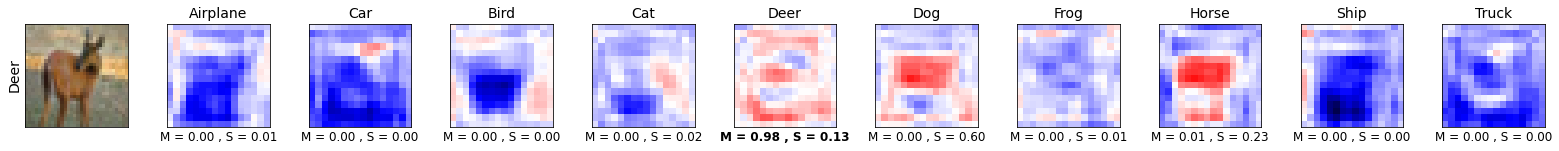

In [68]:
visualize_one_sample(idx_A_wrong_B_wrong, model_A, surrogate_A, fastshap_A)

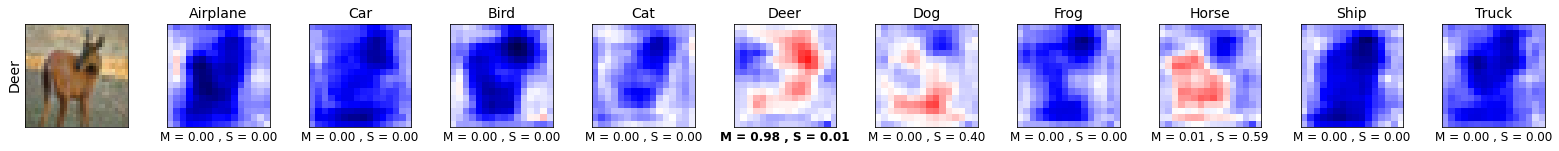

In [69]:
visualize_one_sample(idx_A_wrong_B_wrong, model_B, surrogate_B, fastshap_B)

## Visualize: A_wrong_B_correct

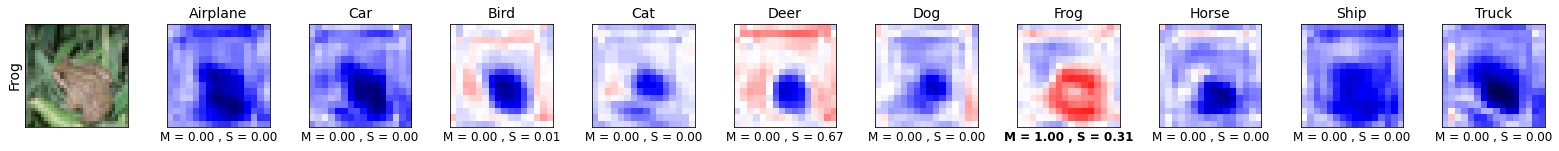

In [70]:
visualize_one_sample(idx_A_wrong_B_correct, model_A, surrogate_A, fastshap_A)

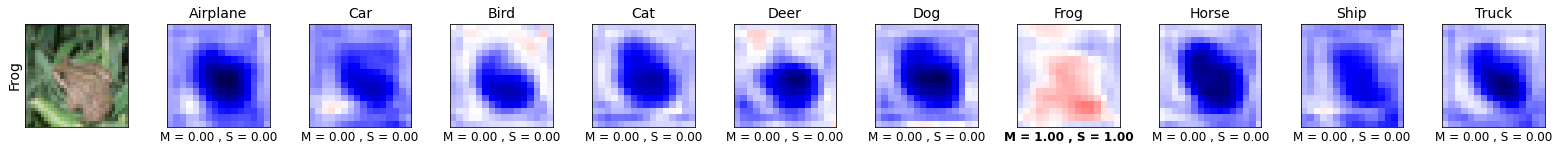

In [71]:
visualize_one_sample(idx_A_wrong_B_correct, model_B, surrogate_B, fastshap_B)

28


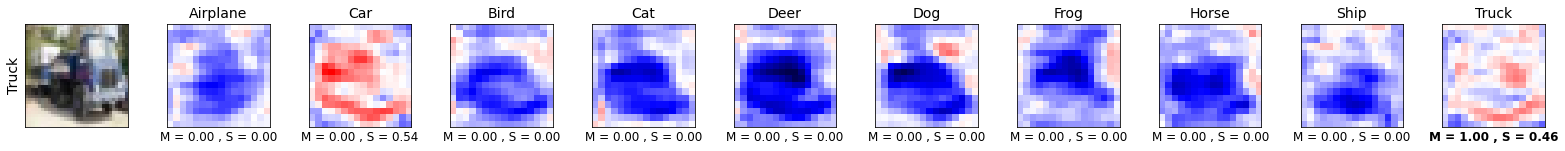

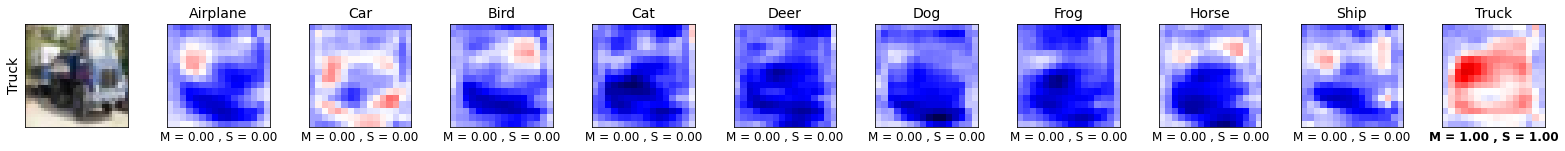

+++++++
25


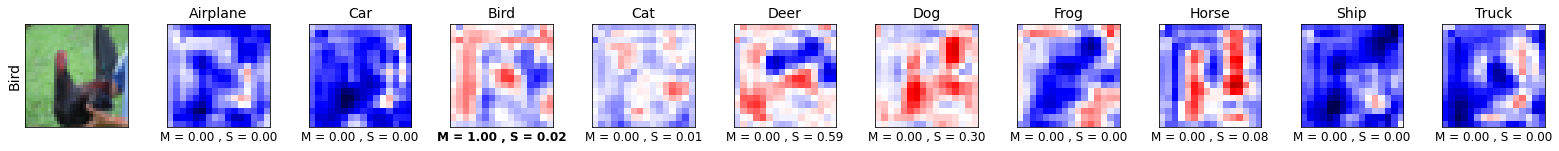

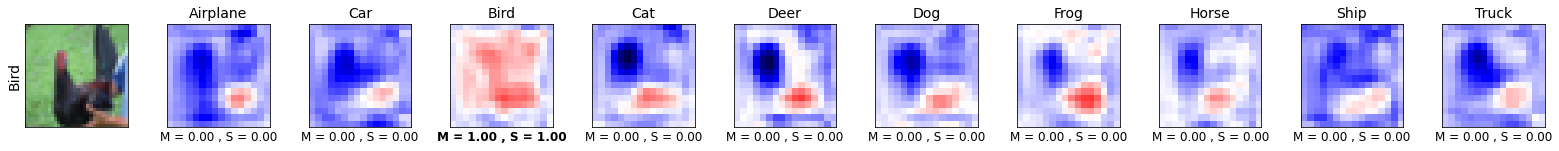

+++++++
4


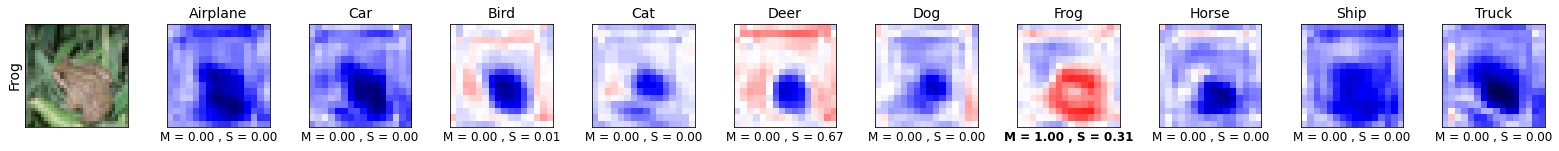

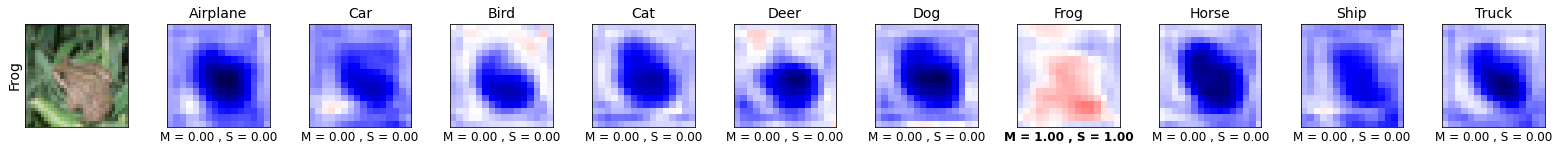

+++++++
76


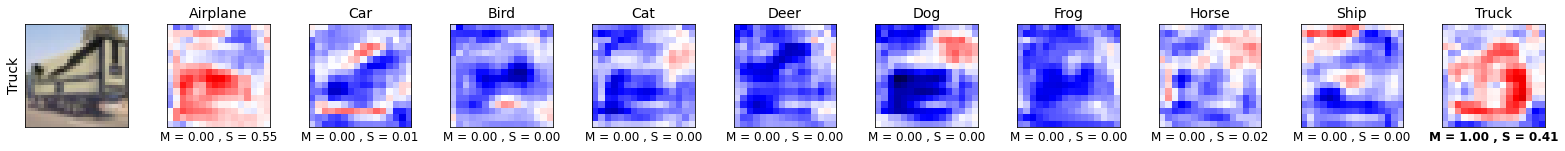

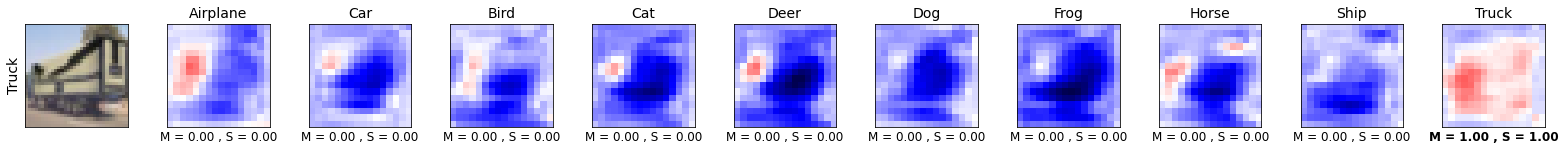

+++++++
53


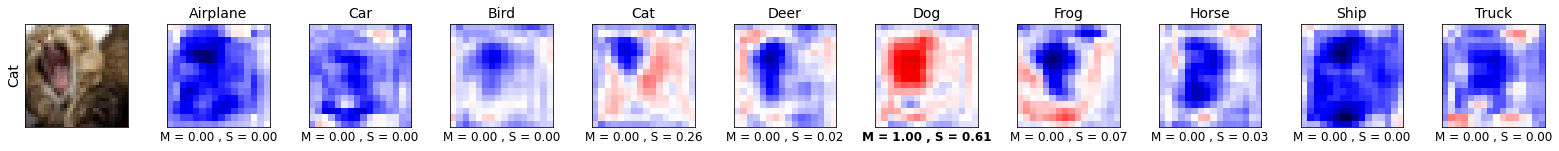

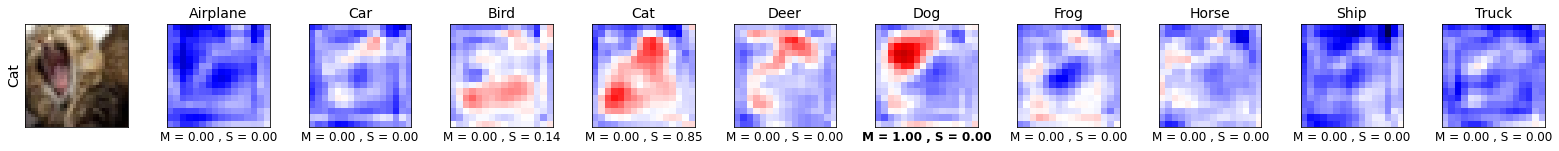

+++++++


In [37]:
for idx in indices:
    print(idx)
    visualize_one_sample(idx, model_A, surrogate_A, fastshap_A)
    visualize_one_sample(idx, model_B, surrogate_B, fastshap_B)
    print("+++++++")

## Visualize: A_correct_B_wrong

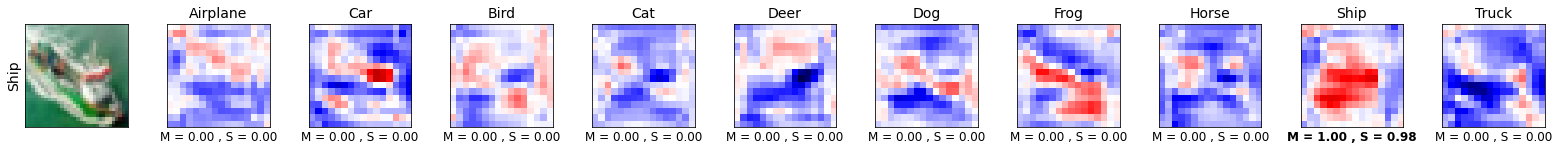

In [72]:
visualize_one_sample(idx_A_correct_B_wrong, model_A, surrogate_A, fastshap_A)

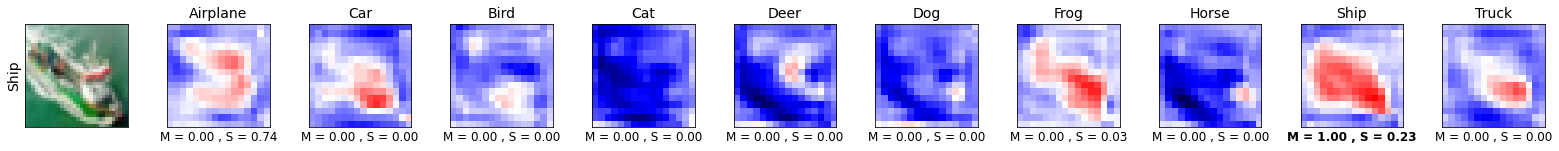

In [73]:
visualize_one_sample(idx_A_correct_B_wrong, model_B, surrogate_B, fastshap_B)

## Visualize: A_correct_B_correct

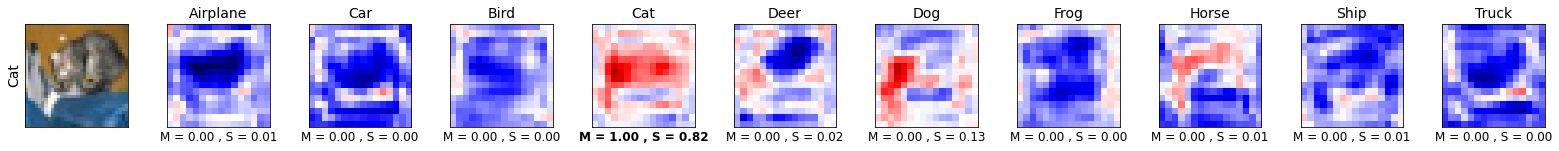

In [74]:
visualize_one_sample(idx_A_correct_B_correct, model_A, surrogate_A, fastshap_A)

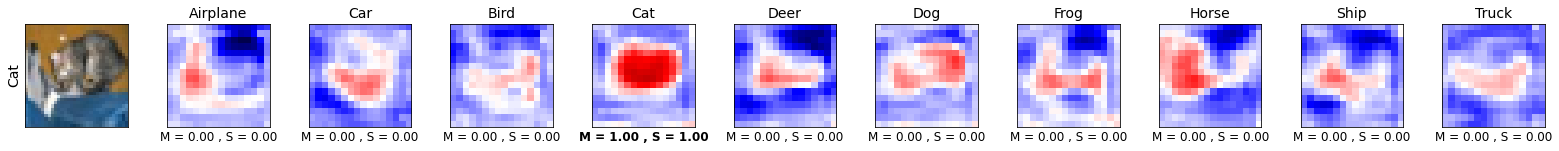

In [75]:
visualize_one_sample(idx_A_correct_B_correct, model_B, surrogate_B, fastshap_B)